In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta, binom, betabinom, chi2, mode
import arviz as az

In [2]:
n = 9
x = 6
a = 2
b = 2

a_posterior = a+x
b_posterior = b+n-x

## Using the exact theoretical Bayesian model

In [3]:
theta_grid = np.linspace(0, 1, num=200)
x_grid     = np.arange(0, 10)

likelihood = beta.pdf(theta_grid, x+1, n-x+1)
prior      = beta.pdf(theta_grid, a, b)

posterior_approx = prior * likelihood

Plot the (exact) prior, likelihood and posterior

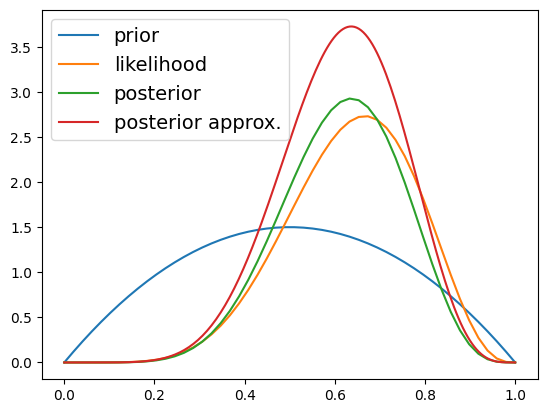

In [4]:
theta_plot = np.linspace(0, 1)
posterior  = beta.pdf(theta_plot, a_posterior, b_posterior)

#plt.figure(figsize=(12,10))
plt.plot(theta_plot, beta.pdf(theta_plot, a, b), label='prior')
plt.plot(theta_plot, beta.pdf(theta_plot, x+1, n-x+1), label='likelihood')
plt.plot(theta_plot, posterior, label='posterior')
plt.plot(theta_grid, posterior_approx, label='posterior approx.')
plt.legend(fontsize=14)

## Simulate from the posterior and from the posterior predictive

### Simulate from the posterior

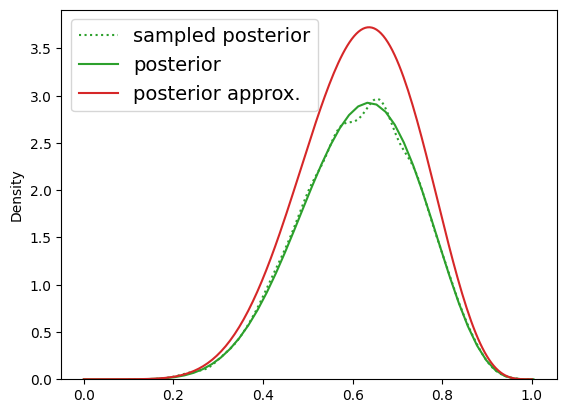

In [5]:
np.random.seed(111)
n_sample = 10**4
posterior_sample = random.choices(theta_grid, weights=posterior_approx, k=n_sample)

#plt.plot(theta_plot, beta.pdf(theta_plot, a, b), label='prior')
#plt.plot(theta_plot, beta.pdf(theta_plot, x+1, n-x+1), label='likelihood')
sns.kdeplot(posterior_sample, label='sampled posterior', color='C2', ls=':')
plt.plot(theta_plot, posterior, label='posterior', color='C2')
plt.plot(theta_grid, posterior_approx, label='posterior approx.', color='C3')
plt.legend(fontsize=14, loc='upper left')

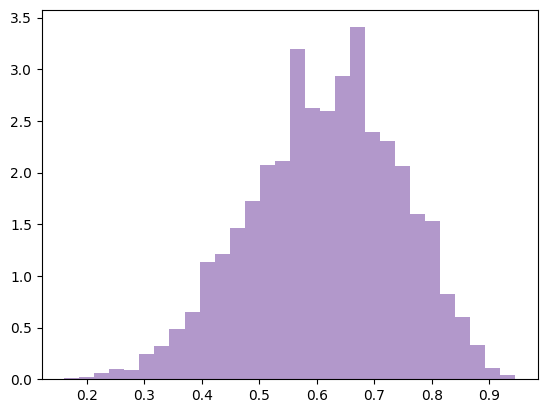

In [6]:
hist = plt.hist(posterior_sample, bins=30, density=True, color='RebeccaPurple', alpha=0.5)

We can approximate the MAP using the mode of the sample.

In [7]:
mode(posterior_sample, keepdims=False)

ModeResult(mode=0.6683417085427136, count=168)

In [8]:
mode(posterior_sample, keepdims=False)[0] # MAP

0.6683417085427136

We can approximate the MAP using the mode of the histogram.

In [9]:
hist[1][np.argmax(hist[0])] # MAP

0.6572864321608041

We normalized the posterior sample, so in the MAP it has a value of one.

<BarContainer object of 30 artists>

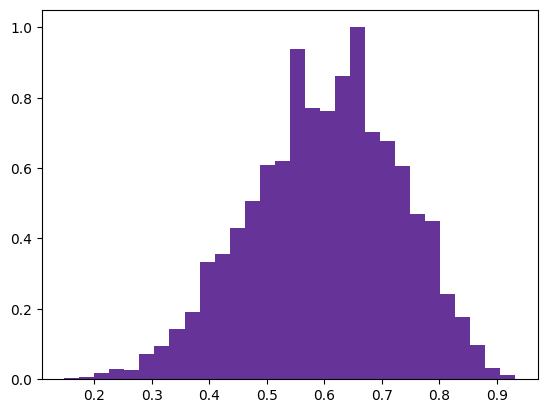

In [10]:
width = (np.diff(hist[1]))[0]
middle_points = hist[1][:-1]
normalized_heights = hist[0] / hist[0].max()
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')

Using the normal approximation to get an interval of $(1-\alpha)\times 100\%$ of posterior probability.

In [11]:
alpha = 0.165
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.44824121, 0.7879397 ])

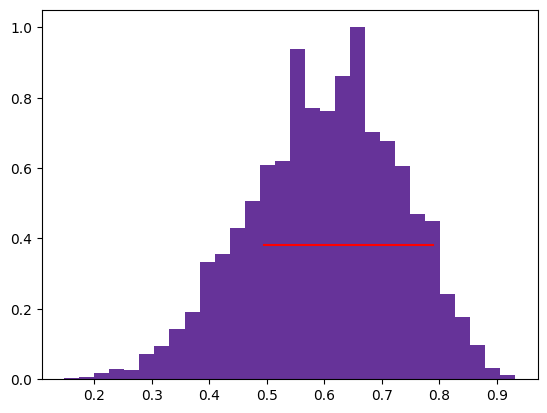

In [12]:
plt.bar(middle_points, normalized_heights, width, color='RebeccaPurple')
plt.axhline(point_cut, extreme_points[0], extreme_points[1], color='r')

### Simulate from the posterior predictive

Plot the (exact) previous and posterior predictives

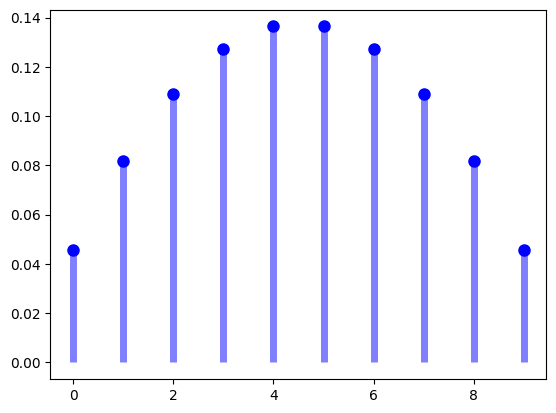

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a, b), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a, b), colors='b', lw=5, alpha=0.5)

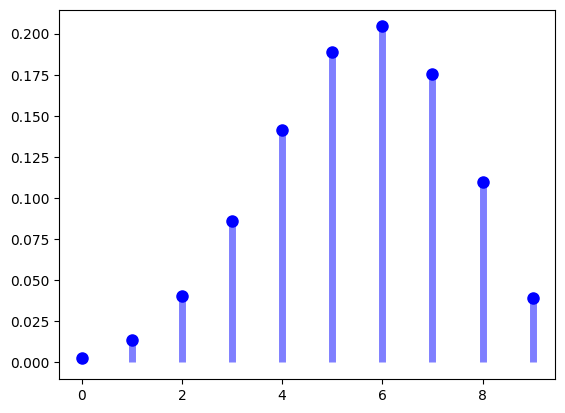

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_grid, betabinom.pmf(x_grid, n, a_posterior, b_posterior), 'bo', ms=8)
ax.vlines(x_grid, 0, betabinom.pmf(x_grid, n, a_posterior, b_posterior), colors='b', lw=5, alpha=0.5)

<Axes: ylabel='Probability'>

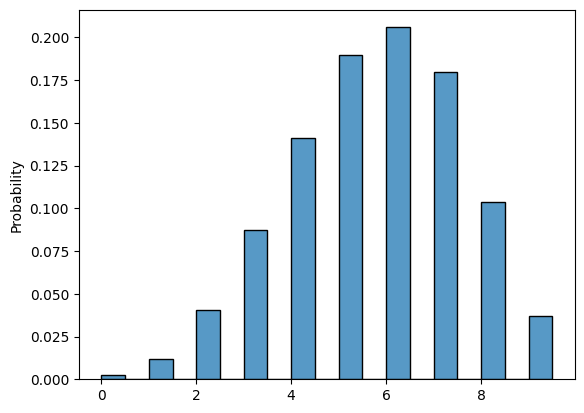

In [15]:
posterior_predictive = binom.rvs(size=n_sample, n=9, p=posterior_sample)
sns.histplot(posterior_predictive, stat='probability', bins=np.arange(0,10,0.5))

## Punctual estimation

In [16]:
posterior_sample = pd.Series(posterior_sample)

### MAP (Maximum a posteriori) $\frac{\alpha-1}{\alpha+\beta-2}$

In [17]:
print('Theoretical MAP: ', (a_posterior-1) / (a_posterior+b_posterior-2))
print('Mode from posterior sample: ', posterior_sample.mode().values[0])

Theoretical MAP:  0.6363636363636364
Mode from posterior sample:  0.6683417085427136


### Posterior mean $\frac{\alpha}{\alpha+\beta}$

In [18]:
print('Theoretical mean a posteriori: ', (a_posterior) / (a_posterior+b_posterior))
print('Mean from posterior sample: ', posterior_sample.mean())

Theoretical mean a posteriori:  0.6153846153846154
Mean from posterior sample:  0.6143201005025125


### Posterior median $\approx \frac{\alpha-1/3}{\alpha+\beta-2/3}$

In [19]:
print('Approx. median a posteriori: ', (a_posterior-1/3) / (a_posterior+b_posterior-2/3))
print('Median from posterior sample: ', posterior_sample.median())

Approx. median a posteriori:  0.6216216216216216
Median from posterior sample:  0.6231155778894473


### Using loss functions

In [20]:
def quadratic_loss(p):
    return sum(posterior_approx*1/2*(p-theta_grid)**2)

In [21]:
approx_quad_loss = np.array([quadratic_loss(p) for p in theta_grid])
theta_grid[approx_quad_loss.argmin()]

0.6130653266331658

In [22]:
def absolute_loss(p):
    return sum(posterior_approx*abs(p-theta_grid))

In [23]:
approx_abs_loss = np.array([absolute_loss(p) for p in theta_grid])
theta_grid[approx_abs_loss.argmin()]

0.6231155778894473

In [24]:
def huber_loss(p, delta=1):
    aux = np.where(np.abs(p-theta_grid) < delta, 1/2*(p-theta_grid)**2 , delta*(np.abs(p-theta_grid)-1/2*delta))
    return sum(aux)

In [25]:
approx_huber_loss = np.array([huber_loss(p) for p in theta_grid])
theta_grid[approx_huber_loss.argmin()]

0.49748743718592964

## Interval estimation

### Credible interval or compatibility interval

Using the normal approximation

In [26]:
alpha = 0.16

In [27]:
point_cut = np.exp(-0.5 * chi2.ppf(1-alpha, 1))
extreme_points = middle_points[normalized_heights >= point_cut][[0,-1]]

extreme_points

array([0.44824121, 0.7879397 ])

Using the theoretical exact posterior

In [28]:
print(beta.ppf(alpha/2, a_posterior, b_posterior), beta.ppf(1-alpha/2, a_posterior, b_posterior))

0.42378508142729054 0.7945639785994926


Using quantiles interval

In [29]:
print(posterior_sample.quantile(alpha/2), posterior_sample.quantile(1-alpha/2))

0.4221105527638191 0.7939698492462312


### Highest posterior density interval (HPDI)

In [30]:
az.hdi(posterior_sample.to_numpy(), hdi_prob=1-alpha)

array([0.42211055, 0.78894472])

## Hypothesis test

$\theta \geq 0.5$

In [31]:
sum(posterior_sample >= 0.5) / n_sample

0.8037

$\theta \geq 0.9$

In [32]:
sum(posterior_sample >= 0.9) / n_sample

0.0029